In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib_venn import venn3
import seaborn as sns

# import custom functions
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from homer_preprocessing import import_homer_diffgene, read_homer_gene_exp, read_annotated_peaks
from plotting_scripts import plot_exp_rpkm, gene_list_bar_plot

In [2]:
workingDirectory = '/home/h1bennet/strains_rna/results/K03_CB6F1_Kupffer_RNA/'
dataDirectory = '/home/ttroutman/strainsKupffer/rnaKupfferF1/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

if not os.path.isdir('./figures/'):
    os.mkdir('./figures/')

To do this analysis we will pull from the differential analysis performed by Ty at the following location:  

     /home/ttroutman/strainsKupffer/rnaKupfferF1/
     
The following two files are relevant  

     /home/ttroutman/strainsKupffer/rnaKupfferF1/c57bl6j_perfect.vs.balbcj_perfect.scatter.txt
     /home/ttroutman/strainsKupffer/rnaKupfferF1/c57bl6j_control.vs.balbcj_control.scatter.txt

In [3]:
diffDir = '/home/ttroutman/strainsKupffer/rnaKupfferF1/rnaDiff/'
rnaQuan = '/home/ttroutman/strainsKupffer/rnaKupfferF1/rnaQuan/rawT.txt'


In [4]:
tpm = pd.read_csv(rnaQuan,
                  index_col=0,
                  sep='\t')

In [5]:
tpm.head()

,balbcj_variants_rep1,balbcj_variants_rep2,balbcj_variants_rep3,balbcj_variants_rep4,c57bl6j_variants_rep1,c57bl6j_variants_rep2,c57bl6j_variants_rep3,c57bl6j_variants_rep4,balbcj_perfect_rep1,balbcj_perfect_rep2,balbcj_perfect_rep3,balbcj_perfect_rep4,c57bl6j_perfect_rep1,c57bl6j_perfect_rep2,c57bl6j_perfect_rep3,c57bl6j_perfect_rep4,balbcj_control_rep1,balbcj_control_rep2,c57bl6j_control_rep1,c57bl6j_control_rep2
Mia2,9.543,6.900,9.917,7.943,9.140,6.621,9.877,7.334,53.511,49.444,51.555,53.470,53.541,49.402,51.630,53.518,57.602,56.337,65.975,60.326
Abraxas1,0.281,0.636,0.591,0.649,0.270,0.488,0.798,0.208,3.666,3.338,2.790,2.993,3.658,3.336,2.801,2.960,2.813,3.878,3.070,3.163
Sugp2,25.282,24.404,19.890,19.560,22.258,23.715,20.708,19.441,11.668,11.443,11.559,10.667,11.422,11.419,11.638,10.723,12.383,11.145,10.554,11.548
March1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,63.040,78.529,67.206,61.269,62.890,78.293,67.056,61.119,55.064,57.794,100.343,77.550
Mob3b,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.214,2.406,2.430,2.275,2.209,2.399,2.425,2.269,3.912,2.739,3.226,2.075


In [6]:
groups = ['balbcj_variants',
          'c57bl6j_variants',
          'balbcj_perfect',
          'c57bl6j_perfect',
          'balbcj_control',
          'c57bl6j_control']

log2tpm_thresh = 3.169925

In [7]:
avg_tpm_dict = {}
for group in groups:
    avg = tpm.loc[:, tpm.columns.str.contains(group)].mean(1)
    avg_tpm_dict[group] = avg
    
avg_tpm_df = pd.DataFrame(avg_tpm_dict)
# log transform data
log_tpm_df = np.log2(avg_tpm_df+1)
# filter on expression
log_tpm_df = log_tpm_df.reindex(log_tpm_df.index[(log_tpm_df > log2tpm_thresh).any(1)])

calculate fold changes for each comparison of interest

# Check with ty that  "variants" are perfectly aligned reads overlapping variants

In [8]:
log_tpm_df['f1_fc_perfect'] = log_tpm_df['c57bl6j_perfect'] - log_tpm_df['balbcj_perfect']
log_tpm_df['f1_fc_variants'] = log_tpm_df['c57bl6j_variants'] - log_tpm_df['balbcj_variants']
log_tpm_df['p1_fc'] = log_tpm_df['c57bl6j_control'] - log_tpm_df['balbcj_control']

### set gene lists
For plotting we don't care about directionality, but for extracting gene lists we will have to
pull out balb biased and c57 biased trans genes

In [9]:
cis = np.abs(log_tpm_df.p1_fc - log_tpm_df.f1_fc_variants) < 1
trans = ((~cis) &(np.abs(log_tpm_df.p1_fc) > 1) & ((np.abs(log_tpm_df.f1_fc_variants) < 1)))
mixed = (~cis) & (~trans)

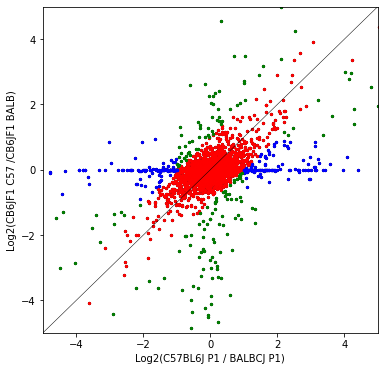

In [10]:
fig, ax = plt.subplots(figsize=(6,6))


ax.plot([-10,10],
        [-10,10],
        c='k',
        linewidth=0.5)

ax.scatter(log_tpm_df.p1_fc,
           log_tpm_df.f1_fc_variants,
           s=5,
           c='k')

ax.scatter(log_tpm_df.p1_fc[cis],
           log_tpm_df.f1_fc_variants[cis],
           s=5,
           c='r')

ax.scatter(log_tpm_df.p1_fc[trans],
           log_tpm_df.f1_fc_variants[trans],
           s=5,
           c='b')

ax.scatter(log_tpm_df.p1_fc[mixed],
           log_tpm_df.f1_fc_variants[mixed],
           s=5,
           c='g')
ax.set_xlabel('Log2(C57BL6J P1 / BALBCJ P1)')
ax.set_ylabel('Log2(CB6JF1 C57 /CB6JF1 BALB)')

ax.set_xlim([-5,5]);
ax.set_ylim([-5,5]);

In [11]:
trans_c57 = ((~cis) & ((log_tpm_df.p1_fc) > 1) & (np.abs(log_tpm_df.f1_fc_variants) < 1))
trans_balb = ((~cis) & ((log_tpm_df.p1_fc) < -1) & (np.abs(log_tpm_df.f1_fc_variants) < 1))
mixed_c57 = ((~cis) & ((np.abs(log_tpm_df.p1_fc) < 1) & ((log_tpm_df.f1_fc_variants) > 1)))
mixed_balb = ((~cis) & ((np.abs(log_tpm_df.p1_fc) < 1) & ((log_tpm_df.f1_fc_variants) < -1)))

In [12]:
lists = [trans_c57, trans_balb, mixed_c57, mixed_balb]
labels = ['trans_c57', 'trans_balb', 'mixed_c57', 'mixed_balb']

In [13]:
len(trans_c57.index[trans_c57])

139

## Write out gene list

In [14]:
if not os.path.isdir('./gene_lists/'):
    os.mkdir('./gene_lists')

In [15]:
for label, genelist in zip(labels, lists):
    with open('./gene_lists/cb6f1_kupffer_'+label+'.txt', 'w') as f:
        f.write('Gene\n')
        for i in genelist.index[genelist].tolist():
            f.write(i+'\n')
        f.close()

# Make plot for only variants

In [16]:
no_vars = (log_tpm_df.balbcj_variants==0) & (log_tpm_df.c57bl6j_variants==0) 

In [17]:
log_tpm_df_filt = log_tpm_df.reindex(log_tpm_df.index[~no_vars])

In [18]:
log_tpm_df_filt.shape

(4407, 9)

In [19]:
cis = np.abs(log_tpm_df_filt.p1_fc - log_tpm_df_filt.f1_fc_variants) < 1
trans = ((~cis) &(np.abs(log_tpm_df_filt.p1_fc) > 1) & ((np.abs(log_tpm_df_filt.f1_fc_variants) < 1)))
mixed = (~cis) & (~trans)

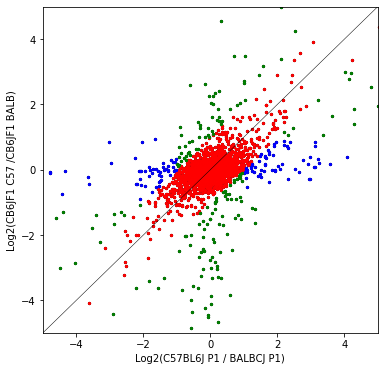

In [20]:
fig, ax = plt.subplots(figsize=(6,6))


ax.plot([-10,10],
        [-10,10],
        c='k',
        linewidth=0.5)

ax.scatter(log_tpm_df_filt.p1_fc,
           log_tpm_df_filt.f1_fc_variants,
           s=5,
           c='k')

ax.scatter(log_tpm_df_filt.p1_fc[cis],
           log_tpm_df_filt.f1_fc_variants[cis],
           s=5,
           c='r')

ax.scatter(log_tpm_df_filt.p1_fc[trans],
           log_tpm_df_filt.f1_fc_variants[trans],
           s=5,
           c='b')

ax.scatter(log_tpm_df_filt.p1_fc[mixed],
           log_tpm_df_filt.f1_fc_variants[mixed],
           s=5,
           c='g')
ax.set_xlabel('Log2(C57BL6J P1 / BALBCJ P1)')
ax.set_ylabel('Log2(CB6JF1 C57 /CB6JF1 BALB)')

ax.set_xlim([-5,5]);
ax.set_ylim([-5,5]);

In [21]:
trans_c57_filt = ((~cis) & ((log_tpm_df_filt.p1_fc) > 1) & (np.abs(log_tpm_df_filt.f1_fc_variants) < 1))
trans_balb_filt = ((~cis) & ((log_tpm_df_filt.p1_fc) < -1) & (np.abs(log_tpm_df_filt.f1_fc_variants) < 1))
mixed_c57_filt = ((~cis) & ((np.abs(log_tpm_df_filt.p1_fc) < 1) & ((log_tpm_df_filt.f1_fc_variants) > 1)))
mixed_balb_filt = ((~cis) & ((np.abs(log_tpm_df_filt.p1_fc) < 1) & ((log_tpm_df_filt.f1_fc_variants) < -1)))

In [22]:
lists = [trans_c57_filt, trans_balb_filt, mixed_c57_filt, mixed_balb_filt]
labels = ['trans_c57_filt', 'trans_balb_filt', 'mixed_c57_filt', 'mixed_balb_filt']

In [23]:
len(trans_balb_filt.index[trans_balb_filt])

56

In [24]:
len(trans_c57_filt.index[trans_c57_filt])

66

In [25]:
for label, genelist in zip(labels, lists):
    with open('./gene_lists/cb6f1_kupffer_'+label+'.txt', 'w') as f:
        f.write('Gene\n')
        for i in genelist.index[genelist].tolist():
            f.write(i+'\n')
        f.close()

# Try to replicate Ty's Analysis

Only difference is I think he uses the p value as well...

pull diff genes

In [26]:
diff_gene_control, tpm_control, tpm_mat_control, tpm_mat_quant_control = import_homer_diffgene(
    diffDir+'/balbcj_control.vs.c57bl6j_control.scatter.txt',
    rnaQuan)

ge all transcripts (23608, 20)
Diff Gene selected transcripts (7667, 7)
ge selected transcripts (7667, 20)


In [27]:
diff_gene_control.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,contrast
RepeatID,,,,,,,
Mia2,2122.428634,0.135183,0.112605,1.200505,0.229943,0.421966,c57bl6j_control-balbcj_control
Sugp2,363.618280,-0.093574,0.177396,-0.527486,0.597856,0.761549,c57bl6j_control-balbcj_control
March1,2224.623579,0.618832,0.139304,4.442298,0.000009,0.000108,c57bl6j_control-balbcj_control
Vapa,1639.783462,-0.061662,0.114556,-0.538267,0.590393,0.756694,c57bl6j_control-balbcj_control
Crat,836.618028,0.089090,0.135613,0.656938,0.511221,0.701739,c57bl6j_control-balbcj_control


In [28]:
diff_gene_variants, tpm_variants, tpm_mat_variants, tpm_mat_quant_variants = import_homer_diffgene(
    diffDir+'/balbcj_variants.vs.c57bl6j_variants.scatter.txt',
    rnaQuan)

ge all transcripts (23608, 20)
Diff Gene selected transcripts (3587, 7)
ge selected transcripts (3587, 20)


In [29]:
df = diff_gene_control.merge(diff_gene_variants,
                             suffixes=['_p1', '_f1'],
                             left_index=True,
                             right_index=True,
                             how='outer')

# i was going to fill na but this would be wrong...
# df['log2FoldChange_f1'].fillna(0, inplace=True)
# df['pvalue_f1'].fillna(1, inplace=True)
# df['padj_f1'].fillna(1, inplace=True)

df = df.dropna(how='any')
df.shape

(2945, 14)

In [30]:
fc = np.log2(2)
padj = 0.05

In [31]:
parental_balb = (df['log2FoldChange_p1'] < -fc) & (df['padj_p1'] < 0.05)
f1_balb = (df['log2FoldChange_f1'] < -fc) & (df['padj_f1'] < 0.05)
parental_c57 = (df['log2FoldChange_p1'] > fc) & (df['padj_p1'] < 0.05)
f1_c57 = (df['log2FoldChange_f1']  > fc) & (df['padj_f1'] < 0.05)

In [32]:
cis_balb = parental_balb & f1_balb
trans_balb = parental_balb & (~f1_balb)
mixed_balb = (~parental_balb) & (f1_balb)
cis_c57 = parental_c57 & f1_c57
trans_c57 = parental_c57 & (~f1_c57)
mixed_c57 = (~parental_c57) & (f1_c57)

In [33]:
lists = [cis_balb, trans_balb, mixed_balb,
         cis_c57, trans_c57, mixed_c57]
labels = ['cis_balb_filt_pval', 'trans_balb_filt_pval', 'mixed_balb_filt_pval',
          'cis_c57_filt_pval', 'trans_c57_filt_pval', 'mixed_c57_filt_pval']

viridis = matplotlib.cm.get_cmap('viridis')
colors = [viridis(0.6), viridis(0.4), viridis(0.2),
          viridis(0.6), viridis(0.4), viridis(0.2)]

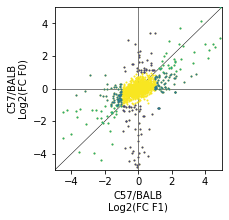

In [34]:
fig, ax = plt.subplots(figsize=(3,3))

# plot bounding lines
ax.plot([-10,10], [-10,10], c='k',
        linewidth=0.5, zorder=1)
ax.axhline(0, c='k', linewidth=0.5,
           zorder=1)
ax.axvline(0, c='k', linewidth=0.5,
           zorder=1)

ax.scatter(df.log2FoldChange_p1,
           df.log2FoldChange_f1,
           s=1,
           c=[viridis(0.99)],
           zorder=2)

for genelist, color in zip(lists, colors):
    ax.scatter(df.loc[genelist, 'log2FoldChange_p1'],
               df.loc[genelist, 'log2FoldChange_f1'],
               s=1,
               c=[color],
               zorder=3)


ax.set_xlabel('C57/BALB\nLog2(FC F1)')
ax.set_ylabel('C57/BALB\nLog2(FC F0)')

ax.set_xlim([-5,5]);
ax.set_ylim([-5,5]);

In [35]:
for label, genelist in zip(labels, lists):
    with open('./gene_lists/cb6f1_kupffer_'+label+'.txt', 'w') as f:
        print(label)
        print(len(df.index[genelist].tolist()))
        f.write('Gene\n')
        for i in df.index[genelist].tolist():
            f.write(i+'\n')
        f.close()

cis_balb_filt_pval
39
trans_balb_filt_pval
63
mixed_balb_filt_pval
52
cis_c57_filt_pval
44
trans_c57_filt_pval
61
mixed_c57_filt_pval
33


# Plot single genes using barplot

In [36]:
tpm_mat = pd.read_csv(rnaQuan,
                      index_col=0,
                      sep='\t')

In [37]:
tpm_mat.columns

Index(['balbcj_variants_rep1', 'balbcj_variants_rep2', 'balbcj_variants_rep3',
       'balbcj_variants_rep4', 'c57bl6j_variants_rep1',
       'c57bl6j_variants_rep2', 'c57bl6j_variants_rep3',
       'c57bl6j_variants_rep4', 'balbcj_perfect_rep1', 'balbcj_perfect_rep2',
       'balbcj_perfect_rep3', 'balbcj_perfect_rep4', 'c57bl6j_perfect_rep1',
       'c57bl6j_perfect_rep2', 'c57bl6j_perfect_rep3', 'c57bl6j_perfect_rep4',
       'balbcj_control_rep1', 'balbcj_control_rep2', 'c57bl6j_control_rep1',
       'c57bl6j_control_rep2'],
      dtype='object')

In [38]:
groups = [[0,1,2,3],
          [4,5,6,7],
          #[8,9,10,11],
          #[12,13,14,15],
          [16,17],
          [18,19]]

group_labels = ['CB6F1 Balb/cJ Variant',
                'CB6F1 C57BL/6J Variant',
                #'CB6F1 Balb/cJ Perfect',
                #'CB6F1 C57BL/6J Perfect',
                'Balb/cJ Control',
                'C57BL/6J Control',]

colors = ['#9ecae1',
          '#a1d99b',
          #'#6baed6',
          #'#74c476',
          '#08519c',
          '#31a354']

In [39]:
legend_elements = []
for lab, col in  zip(group_labels, colors):
    legend_elements.append(Patch(label=lab, color=col))

[]

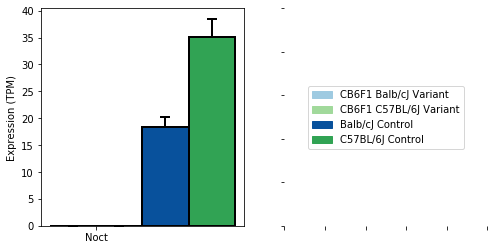

In [40]:
gene = ['Noct']

fig, axs = plt.subplots(1, 2,
                       figsize=(8, 4))
gene_list_bar_plot(gene,
                   tpm,
                   groups=groups,
                   group_labels = group_labels,
                   colors = colors,
                   width=0.2,
                   # relative=True,
                   ax=axs[0])
axs[0].get_legend().remove()
axs[1].legend(handles=legend_elements, loc='center')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')

[]

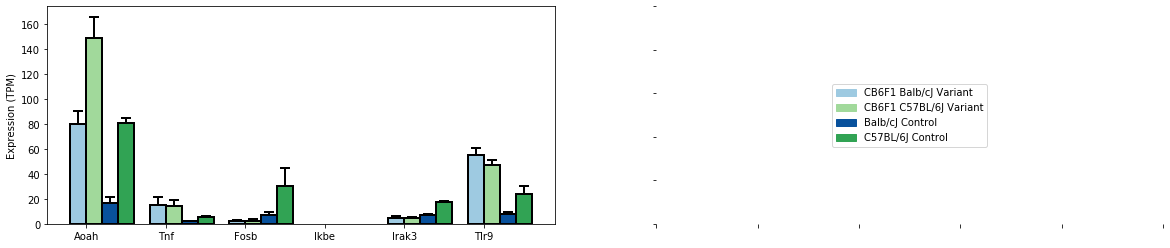

In [41]:
gene = ['Aoah', 'Tnf', 'Fosb', 'Ikbe', 'Irak3', 'Tlr9']

fig, axs = plt.subplots(1, 2,
                       figsize=(20, 4))

gene_list_bar_plot(gene,
                   tpm,
                   groups=groups,
                   group_labels = group_labels,
                   colors = colors,
                   width=0.2,
                   # relative=True,
                   ax=axs[0])

axs[0].get_legend().remove()

axs[1].legend(handles=legend_elements, loc='center')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')

# plt.savefig('./figures/'+gene+'_tpm_barplot.png', bbox_inches='tight')

In [42]:
groups = [[0,1],
          [2,3],
          [4,5]]

group_labels = ['AJ Kupffer Control young',
                'Balb/cJ Kupffer Control young',
                'C57BL/6J Kupffer Control young']

colors = [''#de2d26'',
          '#6baed6',
          '#74c476']

In [43]:
legend_elements = []
for lab, col in  zip(group_labels, colors):
    legend_elements.append(Patch(label=lab, color=col))

[]

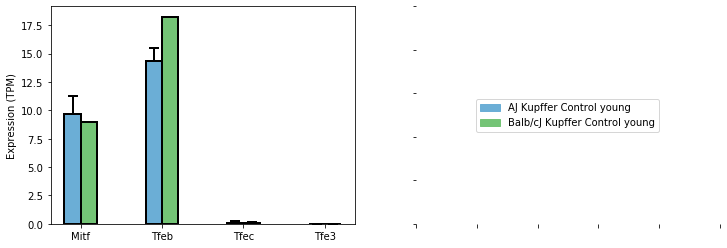

In [44]:
gene = ['Mitf', 'Tfeb', 'Tfec', 'Tfe3']

fig, axs = plt.subplots(1, 2,
                       figsize=(12, 4))

gene_list_bar_plot(gene,
                   tpm,
                   groups=groups,
                   group_labels = group_labels,
                   colors = colors,
                   width=0.2, 
                   ax=axs[0])

axs[0].get_legend().remove()

axs[1].legend(handles=legend_elements, loc='center')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')